In [1]:
from model import *
from AliLoader import *
from ALI_Out import *

from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import manifold
from sklearn import metrics
from scipy import stats
from AliMisc import *

from skopt.space import Real, Integer
from skopt import Optimizer

In [2]:

LS = 512 #Latent Space Size
ColorsNumber = 1 #Number of color (always 1 for x-ray)
isize = 64

name = "Exp_64_512_0.00001_RandomLabel_4.0"
datadir = "./ChestXray-NIHCC-2/"

ExpDir = "./model/"+name



Load dataset

In [3]:
batch_size = 25
TestDF = pd.read_csv(ExpDir+"/TestImagesInfo.csv")
PreProDir = datadir+"PreProcess/Size"+str(isize)
test_dataset = XrayDatasetTensor(PreProDir+"/Tensor"+str(isize)+".pt",PreProDir+"/AllImagesInfo.csv",list(TestDF["name"]))
RealLoader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


len(TestDF)

1000

In [4]:
MNIST_transform = transforms.Compose([transforms.Resize(isize),transforms.ToTensor()])
MNIST_set = dset.MNIST(root="MNIST/", train=True, transform=MNIST_transform, download=True)
MNIST_loader = DataLoader(dataset=MNIST_set,batch_size=batch_size,shuffle=False)

In [5]:
data_transforms = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(isize),
  transforms.RandomVerticalFlip(p=1.0),
  transforms.ToTensor(),
])
#Add Flip
hflip =  DataLoader(XrayDataset(datadir,TestDF, transform=data_transforms), shuffle=False, batch_size=batch_size)

data_transforms = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(isize),
  transforms.RandomHorizontalFlip(p=1.0),
  transforms.ToTensor(),
])
#Add Flip
vflip =  DataLoader(XrayDataset(datadir,TestDF, transform=data_transforms), shuffle=False, batch_size=batch_size)
randray = DataLoader(XrayDataset(datadir,TestDF, transform=data_transforms,shuffle=True), shuffle=False, batch_size=batch_size)

In [6]:

CP = -2 #Checkpoint to load (-2 for latest one, -1 for last epoch)
DisX,DisZ,DisXZ,GenZ,GenX,CP,DiscriminatorLoss,AllAUCs = GenModel(isize,LS,-2,ExpDir,name,ColorsNumber=ColorsNumber)

DisX = DisX.eval()
DisZ = DisZ.eval()
DisXZ = DisXZ.eval()
GenZ = GenZ.eval()
GenX = GenX.eval()



I found this last checkpoint 2121000


In [7]:
def RecLoss(GenX,GenZ,X):
    GenX.eval()
    GenZ.eval()
    Xr = GenX(GenZ(X))
    
    DiffX = Xr - X
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    Xr = Xr.detach().numpy()
    return(RecLoss,DiffX,Xr)
#Generate Alpha Red Map (so transparent) for error
def GetAlphaRedMap():
    #Print Rebuild
    # Get the colormap colors
    cmap = plt.cm.Reds
    AlphaRed = cmap(np.arange(cmap.N))
    # Set alpha
    AlphaRed[:,-1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    AlphaRed = ListedColormap(AlphaRed)
    return(AlphaRed)

In [8]:
import time

In [9]:
AllRecL = []
AllX = []
AllXr = []
AllPath = []
AllErr = []
endtime = time.time()
for Xi,path in RealLoader:
    inittime = time.time()
    #print(inittime-endtime)
    Xn = Xi*2.0 - 1
    Rl,DiffX,Xr = RecLoss(GenX,GenZ,Xn)
    AllErr += list(DiffX)
    AllXr += list(Xr)
    AllRecL += Rl
    AllX += list(Xn.detach().numpy())
    AllPath += list([p.split("/")[-1] for p in path[0]])
    endtime = time.time()
    

In [10]:
ErrDF = pd.DataFrame([AllPath,AllRecL]).transpose()
ErrDF.columns = ["name","RecLoss"]
print(len(ErrDF))

sind = np.argsort(AllRecL)[::-1]

1000


/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


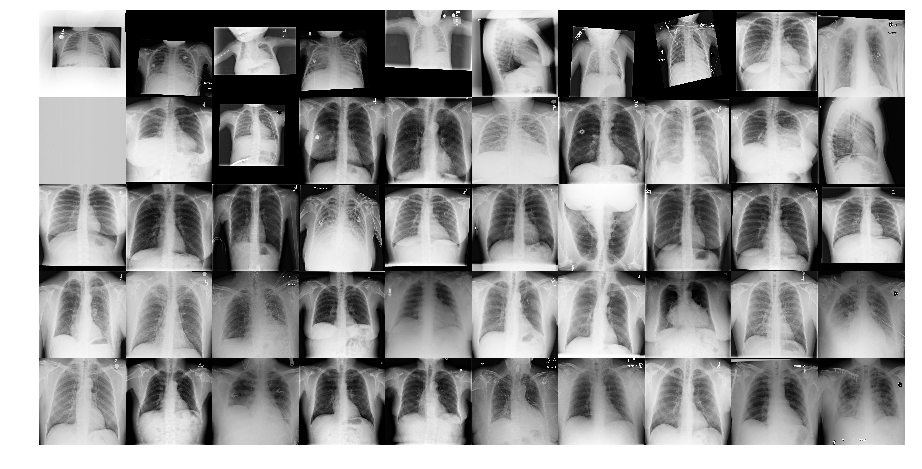

In [11]:

fig = plt.figure(figsize=(15.5,8))
c = 0
for i in range(30):
    c += 1
    plt.subplot(5,10,c)
    ptf = "./ChestXray-NIHCC-2/images/"+AllPath[sind[i]]
    plt.imshow(misc.imread(ptf),cmap="gray",vmax=250,vmin=0)
    plt.axis("off")

for i in range(20):
    c += 1
    plt.subplot(5,10,c)
    ptf = "./ChestXray-NIHCC-2/images/"+AllPath[sind[-20-i]]
    plt.imshow(misc.imread(ptf),cmap="gray",vmax=250,vmin=0)
    plt.axis("off")    

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

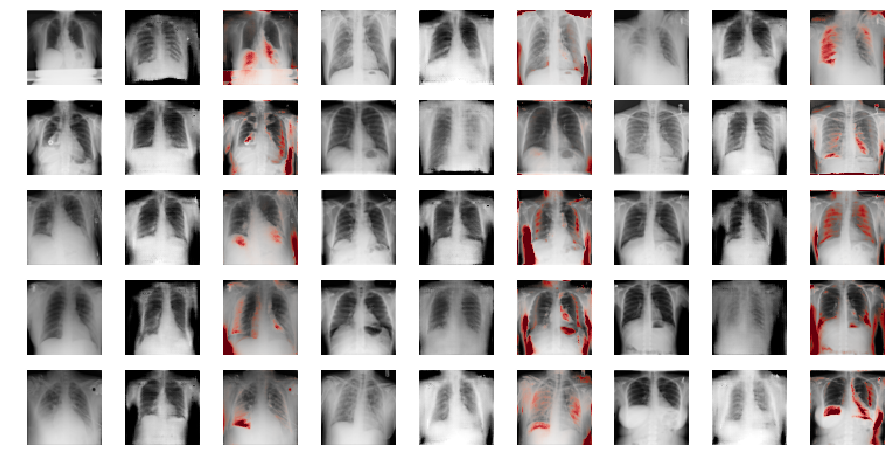

In [12]:

AlphaRed = GetAlphaRedMap()

fig = plt.figure(figsize=(15.5,8))
c = 0
for i in range(3*5):
    c+= 1
    plt.subplot(5,9,c)
    plt.imshow(AllX[i][0],cmap="gray",vmin=-1,vmax=1)
    plt.axis("off")
    
    c+= 1
    plt.subplot(5,9,c)
    plt.imshow(AllXr[sind[i]][0],cmap="gray",vmin=-1,vmax=1)
    plt.axis("off")
    c+= 1
    
    plt.subplot(5,9,c)
    plt.imshow(AllX[i][0],cmap="gray",vmin=-1,vmax=1)
    #plt.title("Rec Error = %.2f" % (np.mean(DiffX[i][0])))
    plt.imshow(AllErr[i][0],cmap=AlphaRed,vmin=0, vmax=1)
    plt.axis("off")


In [13]:
def OutScore(DisX,DisZ,DisXZ,GenZ,GenX,X):
    
    
    z = GenZ(X)
    Xr = GenX(z)
    
    #CatT= torch.cat((DisZ(z), DisX(X)), 1)
    #PredFalse = DisXZ(CatT)
    
    DiffX = Xr - X
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    #PredFalse = PredFalse.detach().numpy()[0][0][0]
    #return(RecLoss,PredFalse)
    return(RecLoss)

In [14]:
def TransformPImg(pim,inputsize,ar):
    tx = ar[0]
    ty = ar[1]
    rot = ar[2]
    sc = ar[3]
    brightness_factor = ar[4]
    contrast_factor = ar[5]
    tim = transforms.functional.affine(pim,angle=rot, translate=[tx,ty], 
                                                   scale=1, shear=0, resample=0, fillcolor=0)
    
    tim = transforms.functional.adjust_brightness(tim, brightness_factor)
    tim = transforms.functional.adjust_contrast(tim, contrast_factor)
    data_transforms = transforms.Compose([transforms.CenterCrop(sc)])
    ftim = data_transforms(tim)
    reim = transforms.functional.resize(ftim,inputsize)
    tim = transforms.functional.to_tensor(reim)
    tim = tim.reshape(1,1,inputsize,inputsize)
    return(ftim,tim)
    



In [15]:
imgs = list(np.array(AllPath)[sind])[100:112]

fig = plt.figure(figsize=(15.5,8))
for imgf in imgs:
    ptf = datadir + "images/"+ imgf
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    #torchvision.transforms.functional.crop(img, i, j, h, w)
    #print(im.shape)
    pim = transforms.functional.to_pil_image(im)
    c = 1
    for i in range(20):
        Err,BestImg,FinalImg = TransformPImg(pim,isize,[0,0,0,im.shape[0],1,1+(i-10)/10.0])
        print(Err)
        plt.subplot(5,10,c)
        plt.imshow(BestImg,cmap="gray")
        plt.title("%.2f %.2f" % (1+(i-10)/10.0,Err))
        plt.axis("off")
        c += 1
    for i in range(20):
        Err,BestImg,FinalImg = TransformPImg(pim,isize,[0,0,0,im.shape[0],1+(i-10)/10.0,1])
        print(Err)
        plt.subplot(5,10,c)
        plt.imshow(BestImg,cmap="gray")
        plt.title("%.2f %.2f" % (1+(i-10)/10.0,Err))
        plt.axis("off")
        c += 1
    break
plt.show()

/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


ValueError: not enough values to unpack (expected 3, got 2)

<Figure size 1116x576 with 0 Axes>

In [59]:


imgs = list(np.array(AllPath)[sind])[-900:]
RandInt = 20
Explore = 5

fig = plt.figure(figsize=(15.5,8))
c = 0
for imgf in imgs:
    ptf = datadir + "images/"+ imgf
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    
    pim = transforms.functional.to_pil_image(im)
    
    space  = [Integer(-200, 200, name='tx'),
          Integer(-200, 200, name='ty'),
          Real(-5,5, name='rot'),
          Integer(500, im.shape[0], name='sc'),
          Real(0.8,1.2, name='Bright'),
          Real(0.8,1.2, name='Contrast')
          ]
   
    
    
    opt = Optimizer(space)

    #Get random value
    
    
    
    
    Fimg = []
    Errs = []
    for it in range(Explore):
        RandTest = []
        if it == 0:
            RandTest.append([0,0,0,im.shape[0],1,1])
            RandTest.append([-50,0,0,im.shape[0],1,1])
            RandTest.append([50,0,0,im.shape[0],1,1])
            
            RandTest.append([0,-50,0,im.shape[0],1,1])
            RandTest.append([0,50,0,im.shape[0],1,1])
            
            RandTest.append([0,0,0,im.shape[0],0.9,1])
            RandTest.append([0,0,0,im.shape[0],1.1,1])
            
            RandTest.append([0,0,0,im.shape[0],1,0.9])
            RandTest.append([0,0,0,im.shape[0],1,1.1])
            
            RandTest.append([0,0,0,im.shape[0]-100,1,1])
            RandTest.append([0,0,0,im.shape[0]-200,1,1])
            RandTest.append([0,0,0,im.shape[0]-300,1,1])
            
        totest = opt.ask(n_points=RandInt)
        RandTest += totest
        TensorTsc = torch.tensor([])
        for i in range(RandInt):
            FullImg,TensorImg = TransformPImg(pim,isize,RandTest[i])
            Fimg.append(FullImg)
            TensorTsc = torch.cat((TensorTsc,TensorImg),0)
        rl = OutScore(DisX,DisZ,DisXZ,GenZ,GenX,TensorTsc*2.0-1.0)
        for i in range(RandInt):
            opt.tell(RandTest[i], rl[i])
            print(rl[i],RandTest[i])
        Errs += rl
    break

/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


0.5729419 [0, 0, 0, 1024, 1, 1]
0.55344456 [-50, 0, 0, 1024, 1, 1]
0.64740133 [50, 0, 0, 1024, 1, 1]
0.6856926 [0, -50, 0, 1024, 1, 1]
0.5371758 [0, 50, 0, 1024, 1, 1]
0.57712376 [0, 0, 0, 1024, 0.9, 1]
0.41424462 [0, 0, 0, 1024, 1.1, 1]
0.56644696 [0, 0, 0, 1024, 1, 0.9]
0.47029445 [0, 0, 0, 1024, 1, 1.1]
0.6577334 [0, 0, 0, 924, 1, 1]
0.6826102 [0, 0, 0, 824, 1, 1]
0.73522633 [0, 0, 0, 724, 1, 1]
0.5903233 [19, 60, 0.46134255247506495, 998, 0.9412303367898732, 1.1311867834025162]
0.72785443 [199, 196, 2.0784504573509093, 796, 0.9211715458306434, 0.8551455185108875]
0.683915 [-25, 4, -2.2884982585116083, 554, 1.0926156741408386, 1.106588041324832]
0.7106248 [-23, 200, -2.363506577717924, 856, 1.0489973055087298, 0.9200363909702671]
0.6871537 [-42, 155, 2.98794786703065, 692, 1.140591685759349, 0.8669485586199507]
0.53063124 [-62, -113, 2.726046472721043, 735, 1.144161292766512, 0.865945165170019]
0.37627202 [-26, -118, -4.629316418617089, 546, 1.1256062700786507, 0.8081402664020682]
0

<Figure size 1116x576 with 0 Axes>

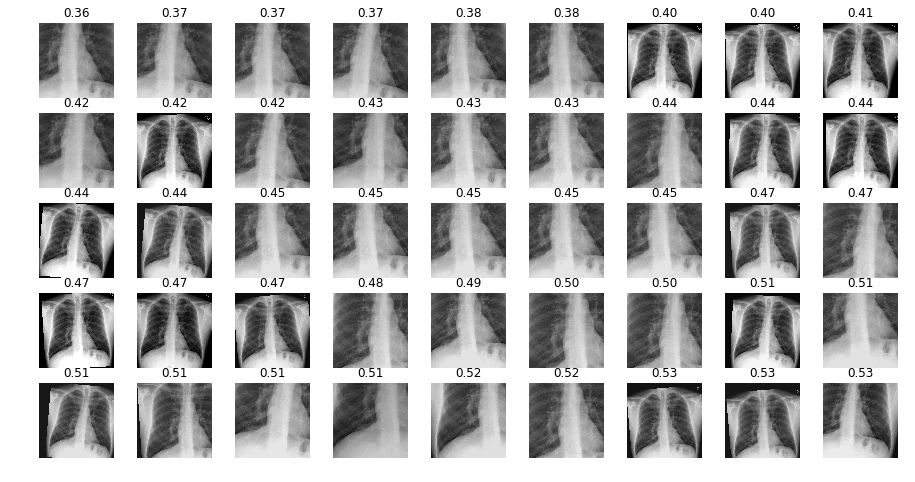

In [61]:
fig = plt.figure(figsize=(15.5,8))
c = 1
for i in np.argsort(Errs):
    plt.subplot(5,9,c)
    plt.imshow(Fimg[i],cmap="gray")
    plt.title("%.2f" % (Errs[i]))
    plt.axis("off")
    c += 1
    if c > 5*9:
        break
plt.show()

In [ ]:
#rl = RecLoss(GenX,GenZ,tim*2.0-1.0)
    
    rl = OutScore(DisX,DisZ,DisXZ,GenZ,GenX,tim*2.0-1.0)
    #print(rl[0],dl[0])
    #comb = rl[0]-dl[0]
    
    return(rl[0],ftim,tim)

In [ ]:
imgs = list(np.array(AllPath)[sind])[:13]+list(np.array(AllPath)[sind])[100:112]


#imgs = list(np.array(AllPath)[sind])[10:13]+list(np.array(AllPath)[sind])[-2:]

RandInt = 20
Explore = 50

#RandInt = 2
#Explore = 2
fig = plt.figure(figsize=(15.5,8))
c = 0
for imgf in imgs:
    ptf = datadir + "images/"+ imgf
    im = misc.imread(ptf)
    if len(im.shape) > 2:
        im = im[:, :, 0]
    #Add color chanel
    im = im[:,:,None]
    #torchvision.transforms.functional.crop(img, i, j, h, w)
    #print(im.shape)
    pim = transforms.functional.to_pil_image(im)
    
    space  = [Integer(-500, 500, name='tx'),
          Integer(-500, 500, name='ty'),
          Real(-5,5, name='rot'),
          Integer(500, 1024, name='sc'),
          Real(1,1.01, name='Bright'),
          Real(1,1.01, name='Contrast')
          ]
   
    
    
    opt = Optimizer(space)

    #Get random value
    RandTest = []
    for i in range(RandInt):
        totest = opt.ask()
        RandTest.append(totest)
    for i in range(RandInt):
        Err,_,_ = TransformPImg(pim,isize,RandTest[i])
        opt.tell(RandTest[i], Err)
    #Gen init val
    Err,_,_ = TransformPImg(pim,isize,[0,0,0,im.shape[0],1,1])
    InitErr = Err
    opt.tell([0,0,0,im.shape[0],1,1], Err)
    
    for i in range(Explore):
        totest = opt.ask()
        f_val,_,_ = TransformPImg(pim,isize,totest)
        opt.tell(totest, f_val)
        #print(f_val)
    BestXi = opt.Xi[np.argsort(opt.yi)[0]]
    Err,BestImg,FinalImg = TransformPImg(pim,isize,BestXi)
    FinalErr = Err
    c += 1
    plt.subplot(5,9,c)
    plt.imshow(pim,cmap="gray")
    plt.title("%.2f" % (InitErr))
    plt.axis("off")
    c += 1
    plt.subplot(5,9,c)
    plt.imshow(BestImg,cmap="gray")
    plt.title("%.2f" % (FinalErr))
    plt.axis("off")
    c += 1
    print(InitErr,FinalErr,BestXi)
    break
plt.show()